<a href="https://colab.research.google.com/github/thatipartiashritha/detecting_misinformation_using_decision_trees/blob/main/detecting_misinformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake news detection

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [4]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [5]:
fake.shape

(23481, 4)

In [6]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [7]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [8]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [9]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [10]:
# Check the data
data.head()

,title,text,subject,date,target
0,Clinton knocks Trump for cheering housing bubb...,WASHINGTON (Reuters) - Democrat Hillary Clinto...,politicsNews,"May 24, 2016",true
1,"India ""disappointed"" with China blocking bid t...",NEW DELHI (Reuters) - India is disappointed ...,worldnews,"November 2, 2017",true
2,"WTO chief won't debate Trump, but rallies supp...",GENEVA (Reuters) - The head of the World Trade...,politicsNews,"July 27, 2016",true
3,Americans UNLOAD On Trump For Threatening Nor...,Donald Trump is a madman putting our nation on...,News,"January 3, 2017",fake
4,Wait Until You See The Insane Tweet The Offic...,It appears that someone has possibly hacked th...,News,"May 4, 2016",fake


In [11]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Clinton knocks Trump for cheering housing bubb...,WASHINGTON (Reuters) - Democrat Hillary Clinto...,politicsNews,true
1,"India ""disappointed"" with China blocking bid t...",NEW DELHI (Reuters) - India is disappointed ...,worldnews,true
2,"WTO chief won't debate Trump, but rallies supp...",GENEVA (Reuters) - The head of the World Trade...,politicsNews,true
3,Americans UNLOAD On Trump For Threatening Nor...,Donald Trump is a madman putting our nation on...,News,fake
4,Wait Until You See The Insane Tweet The Offic...,It appears that someone has possibly hacked th...,News,fake


In [12]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,WASHINGTON (Reuters) - Democrat Hillary Clinto...,politicsNews,true
1,NEW DELHI (Reuters) - India is disappointed ...,worldnews,true
2,GENEVA (Reuters) - The head of the World Trade...,politicsNews,true
3,Donald Trump is a madman putting our nation on...,News,fake
4,It appears that someone has possibly hacked th...,News,fake


In [13]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,washington (reuters) - democrat hillary clinto...,politicsNews,true
1,new delhi (reuters) - india is disappointed ...,worldnews,true
2,geneva (reuters) - the head of the world trade...,politicsNews,true
3,donald trump is a madman putting our nation on...,News,fake
4,it appears that someone has possibly hacked th...,News,fake


In [14]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [15]:
# Check
data.head()

,text,subject,target
0,washington reuters democrat hillary clinton s...,politicsNews,true
1,new delhi reuters india is disappointed by ...,worldnews,true
2,geneva reuters the head of the world trade or...,politicsNews,true
3,donald trump is a madman putting our nation on...,News,fake
4,it appears that someone has possibly hacked th...,News,fake


In [16]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
data.head()

,text,subject,target
0,washington reuters democrat hillary clinton se...,politicsNews,true
1,new delhi reuters india disappointed china dec...,worldnews,true
2,geneva reuters head world trade organization s...,politicsNews,true
3,donald trump madman putting nation brink world...,News,fake
4,appears someone possibly hacked gop official t...,News,fake


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


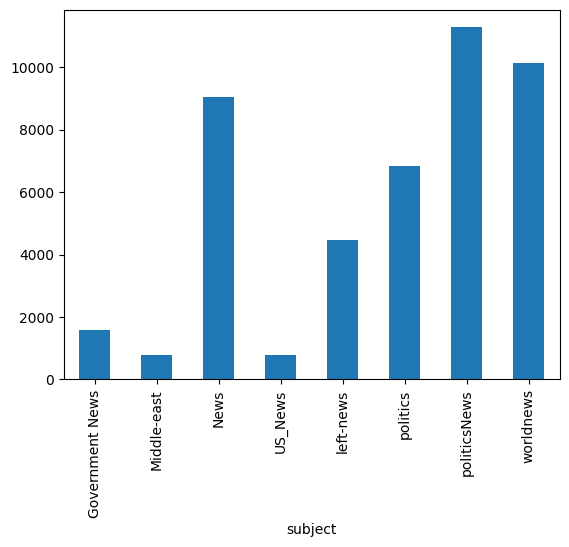

In [18]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


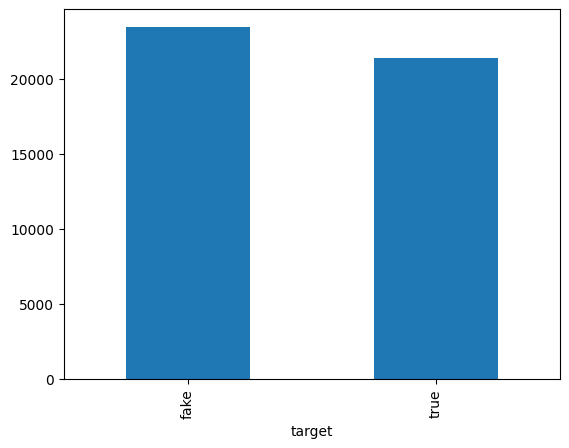

In [19]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

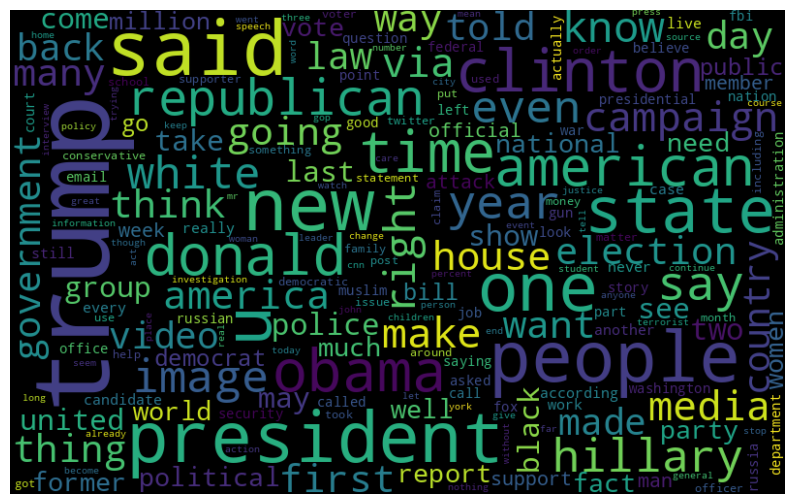

In [20]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

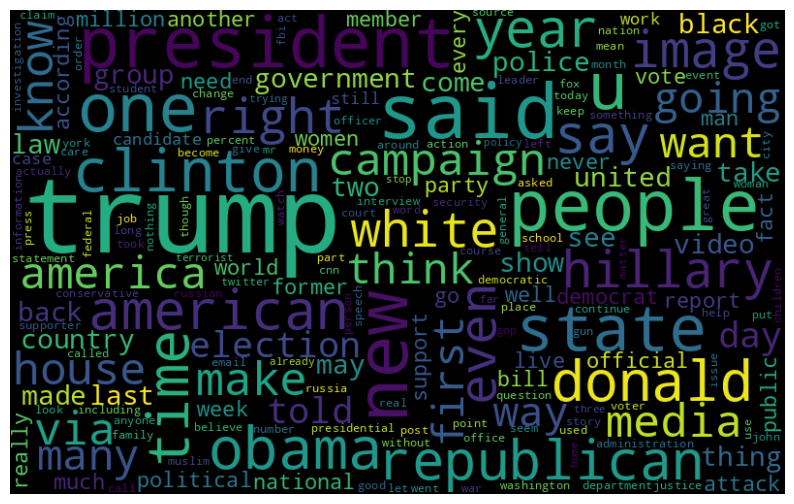

In [21]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

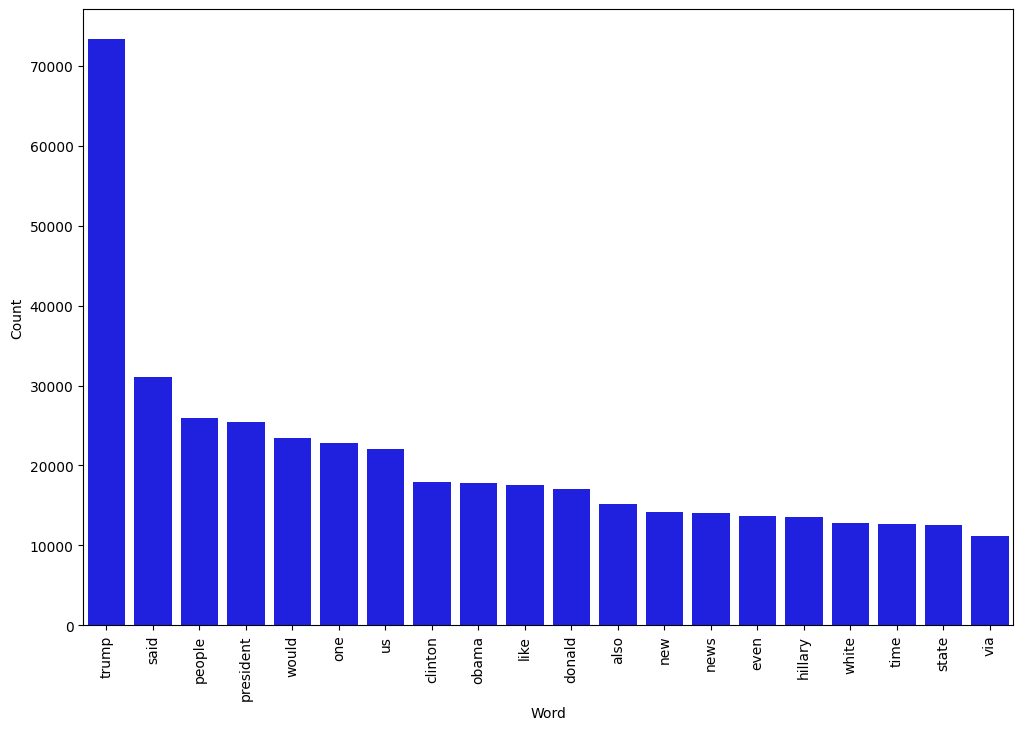

In [23]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

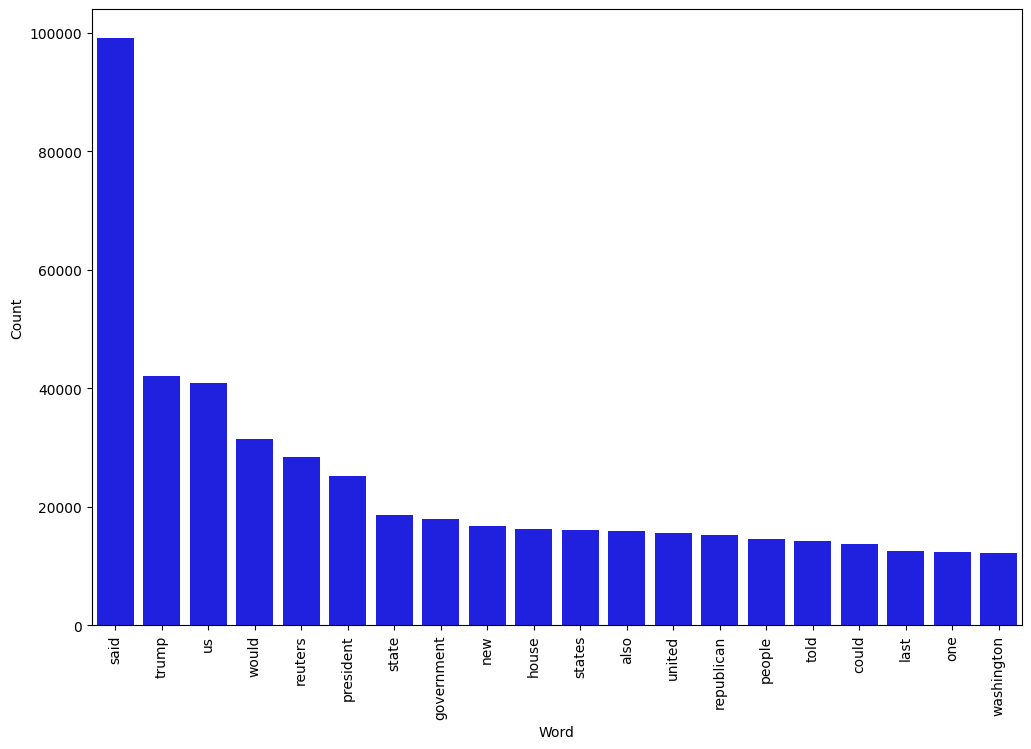

In [24]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [25]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [26]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Logistic regression

In [27]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.76%


Confusion matrix, without normalization


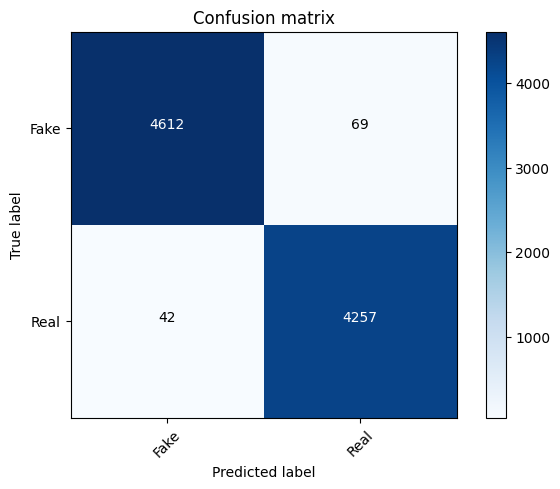

In [28]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree Classifier

In [29]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20,
                                           splitter='best',
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.68%


Confusion matrix, without normalization


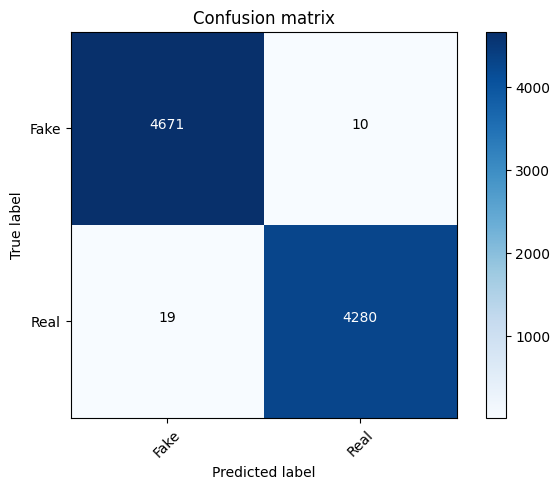

In [30]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.13%


Confusion matrix, without normalization


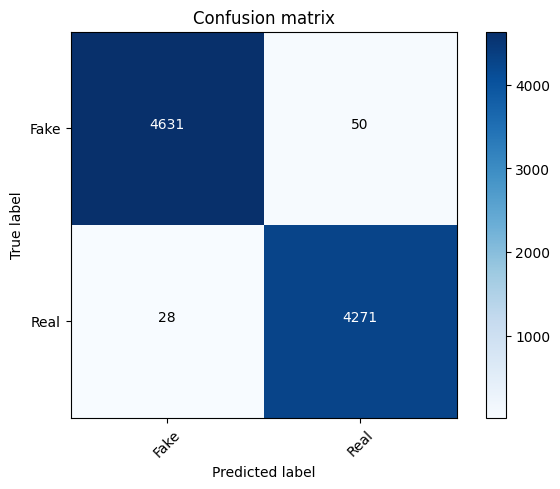

In [32]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])